In [18]:
import json
import re

# JSON dosyasını okuma
input_file = "Metrics.json"
output_file = "anonymized_metrics.json"

with open(input_file, "r", encoding="utf-8") as file:
    data = json.load(file)

# Anonimleştirme fonksiyonu
def anonymize_data(data):
    anonymized_data = []
    class_mapping = {}
    
    for i, item in enumerate(data):
        # Sınıf isimlerini anonimleştir
        original_name = item["name"]
        anonymized_name = f"Class{i+1}.cs"
        class_mapping[original_name] = anonymized_name
        
        # Yeni anonimleştirilmiş item oluşturma
        anonymized_item = {
            "key": f"Project:Module/Class{i+1}.cs",
            "name": anonymized_name,
            "qualifier": item["qualifier"],
            "path": f"Project/Module/Class{i+1}.cs",
            "language": item["language"],
            "measures": item["measures"],
            "commit_count": item["commit_count"],
            "commit_dates_and_types": [
                {"date": "2024-01-01T00:00:00Z", "change_type": commit["change_type"]}
                for commit in item["commit_dates_and_types"]
            ]
        }
        anonymized_data.append(anonymized_item)
    
    return anonymized_data, class_mapping

# Veriyi anonimleştir
anonymized_data, class_mapping = anonymize_data(data)

# Yeni anonimleştirilmiş JSON dosyasını yazma
with open(output_file, "w", encoding="utf-8") as file:
    json.dump(anonymized_data, file, indent=4, ensure_ascii=False)

print(f"Anonimleştirilmiş dosya oluşturuldu: {output_file}")


Anonimleştirilmiş dosya oluşturuldu: anonymized_metrics.json


In [19]:
import json
import pandas as pd

# JSON dosyasını yükleme
file_path = 'anonymized_metrics.json'  
with open(file_path, 'r') as file:
    data = json.load(file)

# Metrikleri düzenleme ve DataFrame'e dönüştürme
class_data = []
for item in data:
    def safe_float(value, default=0):
        """Değeri güvenle float'a çevir, yoksa varsayılan değeri ata."""
        try:
            return float(value) if value != 'None' else default
        except ValueError:
            return default

    # Edit edilen commit'leri hesaplama
    edit_count = sum(1 for commit in item.get("commit_dates_and_types", []) if commit['change_type'] == 'edit')

    class_info = {
        "name": item["name"],
        "complexity": safe_float(next((m['value'] for m in item['measures'] if m['metric'] == 'complexity'), None)),
        "ncloc": safe_float(next((m['value'] for m in item['measures'] if m['metric'] == 'ncloc'), None)),
        "coverage": safe_float(next((m['value'] for m in item['measures'] if m['metric'] == 'coverage'), 0)),  # Test kapsamı için varsayılan değer 0
        "uncovered_lines": safe_float(next((m['value'] for m in item['measures'] if m['metric'] == 'uncovered_lines'), None)),
        "functions": safe_float(next((m['value'] for m in item['measures'] if m['metric'] == 'functions'), None)),
        "security_rating": safe_float(next((m['value'] for m in item['measures'] if m['metric'] == 'security_rating'), 1.0)),  # Varsayılan güvenlik seviyesi
        "edit_count": edit_count  # Edit edilen commit'lerin sayısı
    }
    class_data.append(class_info)

# DataFrame oluşturma
df = pd.DataFrame(class_data)

# Eksik değerleri doldurma
for column in ['complexity', 'ncloc', 'uncovered_lines', 'functions']:
    df[column].fillna(df[column].mean(), inplace=True)  # Eksik değerleri sütun ortalamasıyla doldur

# İlk birkaç satırı gözlemleme
print("Verilerin ilk 5 satırı:")
print(df.head())


Verilerin ilk 5 satırı:
        name  complexity  ncloc  coverage  uncovered_lines  functions  \
0  Class1.cs         8.0   10.0     100.0              0.0        8.0   
1  Class2.cs         1.0   11.0     100.0              0.0        1.0   
2  Class3.cs        15.0  110.0      51.1             33.0        8.0   
3  Class4.cs         0.0   14.0       0.0              0.0        0.0   
4  Class5.cs         0.0   14.0       0.0              0.0        0.0   

   security_rating  edit_count  
0              1.0           0  
1              1.0           6  
2              1.0           3  
3              1.0           4  
4              1.0           4  


In [20]:
# Sınıfların genel istatistiklerini çıkarma
print("Genel metrik istatistikleri:")
print(df.describe())

# Karmaşıklık ve işlev sayısı ilişkisini inceleme
print("Karmaşıklık ve işlev sayısı (ilk 5 sınıf):")
print(df[['name', 'complexity', 'functions']].head())

# Test kapsama oranını gözlemleme
print("Test kapsamı ve uncovered_lines (ilk 5 sınıf):")
print(df[['name', 'coverage', 'uncovered_lines']].head())


Genel metrik istatistikleri:
       complexity       ncloc    coverage  uncovered_lines  functions  \
count   63.000000   63.000000   63.000000        63.000000  63.000000   
mean     5.809524   25.523810   77.388889         3.714286   4.603175   
std      5.570247   29.837115   38.348412        15.226705   4.278754   
min      0.000000    7.000000    0.000000         0.000000   0.000000   
25%      2.000000   10.000000   69.000000         0.000000   2.000000   
50%      4.000000   14.000000  100.000000         0.000000   3.000000   
75%      9.000000   25.500000  100.000000         0.000000   8.000000   
max     22.000000  149.000000  100.000000       114.000000  16.000000   

       security_rating  edit_count  
count             63.0   63.000000  
mean               1.0    2.047619  
std                0.0    2.478479  
min                1.0    0.000000  
25%                1.0    0.000000  
50%                1.0    0.000000  
75%                1.0    4.000000  
max              

In [21]:
def calculate_code_complexity_risk(row):
    # Karmaşıklık ve ncloc için normalizasyon
    complexity_risk = min(row['complexity'] / 20, 1.0)  # 20 üstü karmaşıklık tam risk
    ncloc_risk = min(row['ncloc'] / 200, 1.0)  # 200 üstü satır tam risk
    return 0.5 * complexity_risk + 0.5 * ncloc_risk


In [22]:
def calculate_testability_risk(row):
    # Test kapsama ve uncovered_lines için normalizasyon
    uncovered_risk = min(row['uncovered_lines'] / 30, 1.0)  # 30 satırdan fazla eksik test tam risk
    coverage_risk = 1 - min(row['coverage'] / 100, 1.0)  # 100% kapsama 0 risk
    return 0.5 * uncovered_risk + 0.5 * coverage_risk


In [23]:
def calculate_change_stability_risk(row):
    # Functions ve edit_count için normalizasyon
    functions_risk = min(row['functions'] / 15, 1.0)  # 15 metot üstü tam risk
    edit_count_risk = min(row['edit_count'] / 10, 1.0)  # 10 düzenleme üstü tam risk
    return 0.5 * functions_risk + 0.5 * edit_count_risk


In [24]:
def calculate_security_risk(row):
    # Security rating: 1.0 güvenli, diğer değerler tam risk
    return 1.0 if row['security_rating'] != 1.0 else 0.0


In [25]:
# Alt riskleri hesaplayarak DataFrame'e ekleme
df['complexity_risk'] = df.apply(calculate_code_complexity_risk, axis=1)
df['testability_risk'] = df.apply(calculate_testability_risk, axis=1)
df['change_stability_risk'] = df.apply(calculate_change_stability_risk, axis=1)
df['security_risk'] = df.apply(calculate_security_risk, axis=1)

# İlk birkaç satırı gözlemleme
print("Alt riskler (normalleştirilmiş):")
print(df[['name', 'complexity_risk', 'testability_risk', 'change_stability_risk', 'security_risk']].head())


Alt riskler (normalleştirilmiş):
        name  complexity_risk  testability_risk  change_stability_risk  \
0  Class1.cs           0.2250            0.0000               0.266667   
1  Class2.cs           0.0525            0.0000               0.333333   
2  Class3.cs           0.6500            0.7445               0.416667   
3  Class4.cs           0.0350            0.5000               0.200000   
4  Class5.cs           0.0350            0.5000               0.200000   

   security_risk  
0            0.0  
1            0.0  
2            0.0  
3            0.0  
4            0.0  


In [26]:
# Karakteristik hesaplamaları
def calculate_modifiability(row):
    # Modifiability = %60 complexity + %40 change_stability
    return 0.6 * row['complexity_risk'] + 0.4 * row['change_stability_risk']

def calculate_testability(row):
    # Testability = %70 testability_risk + %30 security_risk
    return 0.7 * row['testability_risk'] + 0.3 * row['security_risk']

# Karakteristikleri DataFrame'e ekleme
df['modifiability'] = df.apply(calculate_modifiability, axis=1)
df['testability'] = df.apply(calculate_testability, axis=1)

# İlk birkaç satırı gözlemleme
print("Karakteristikler (normalleştirilmiş, ilk 5 satır risk değerleri):")
print(df[['name', 'modifiability', 'testability']].head())


Karakteristikler (normalleştirilmiş, ilk 5 satır risk değerleri):
        name  modifiability  testability
0  Class1.cs       0.241667      0.00000
1  Class2.cs       0.164833      0.00000
2  Class3.cs       0.556667      0.52115
3  Class4.cs       0.101000      0.35000
4  Class5.cs       0.101000      0.35000


In [27]:
# Maintainability risk hesaplama
def calculate_maintainability_risk(row):
    # Maintainability = %70 modifiability + %30 testability
    return 0.7 * row['modifiability'] + 0.3 * row['testability']

# Maintainability risk ekleme
df['maintainability_risk'] = df.apply(calculate_maintainability_risk, axis=1)

# İlk birkaç satırı gözlemleme
print("Maintainability Risk (ilk 5 satır):")
print(df[['name', 'modifiability', 'testability', 'maintainability_risk']].head())


Maintainability Risk (ilk 5 satır):
        name  modifiability  testability  maintainability_risk
0  Class1.cs       0.241667      0.00000              0.169167
1  Class2.cs       0.164833      0.00000              0.115383
2  Class3.cs       0.556667      0.52115              0.546012
3  Class4.cs       0.101000      0.35000              0.175700
4  Class5.cs       0.101000      0.35000              0.175700


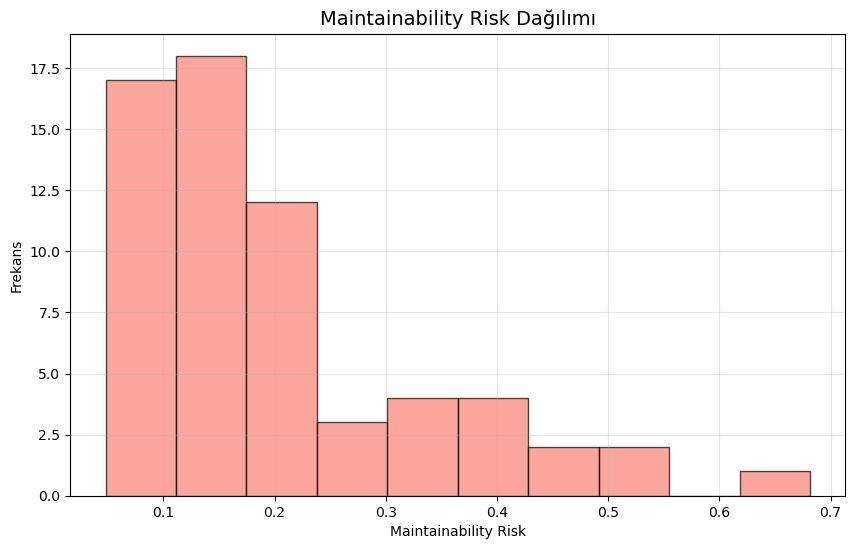

In [28]:
import matplotlib.pyplot as plt

# Maintainability risk histogramı
plt.figure(figsize=(10, 6))
plt.hist(df['maintainability_risk'], bins=10, color='salmon', edgecolor='black', alpha=0.7)
plt.title("Maintainability Risk Dağılımı", fontsize=14)
plt.xlabel("Maintainability Risk")
plt.ylabel("Frekans")
plt.grid(alpha=0.3)
plt.show()


In [37]:
# En riskli sınıfları seçme
most_risky_classes = df.sort_values(by='maintainability_risk', ascending=False).head(5)

# Öneriler oluşturma fonksiyonu
def generate_recommendations(row):
    recommendations = []
    # Modifiability kontrolü
 # Modifiability kontrolü
    if row['modifiability'] > 0.6:
        recommendations.append("Karmaşıklığı azaltın ve kodu daha modüler hale getirin.")
    # Testability kontrolü
    if row['testability'] > 0.6:
        recommendations.append("Test kapsamını artırın ve uncovered lines sorunlarını çözün.")
    # Eğer hiçbir öneri yoksa
    if not recommendations:
        recommendations.append("Genel kod kalitesini iyileştirmek için sınıf yapısını gözden geçirin.")
    return "; ".join(recommendations)

# Önerileri ekleyerek yeni bir sütun oluşturma
most_risky_classes['recommendations'] = most_risky_classes.apply(generate_recommendations, axis=1)

# Sonuçları yazdırma
print("Maintainability'e Göre Riskli Sınıflar ve Öneriler:")
for index, row in most_risky_classes.iterrows():
    print(f"Sınıf Adı: {row['name']}")
    print(f"Maintainability Risk: {row['maintainability_risk']:.4f}")
    print(f"Öneriler: {row['recommendations']}")
    print("-" * 50)


Maintainability'e Göre Riskli Sınıflar ve Öneriler:
Sınıf Adı: Class32.cs
Maintainability Risk: 0.6815
Öneriler: Karmaşıklığı azaltın ve kodu daha modüler hale getirin.; Test kapsamını artırın ve uncovered lines sorunlarını çözün.
--------------------------------------------------
Sınıf Adı: Class3.cs
Maintainability Risk: 0.5460
Öneriler: Genel kod kalitesini iyileştirmek için sınıf yapısını gözden geçirin.
--------------------------------------------------
Sınıf Adı: Class17.cs
Maintainability Risk: 0.5422
Öneriler: Karmaşıklığı azaltın ve kodu daha modüler hale getirin.
--------------------------------------------------
Sınıf Adı: Class48.cs
Maintainability Risk: 0.4536
Öneriler: Genel kod kalitesini iyileştirmek için sınıf yapısını gözden geçirin.
--------------------------------------------------
Sınıf Adı: Class22.cs
Maintainability Risk: 0.4342
Öneriler: Genel kod kalitesini iyileştirmek için sınıf yapısını gözden geçirin.
--------------------------------------------------


In [31]:
# Ortalama risk hesaplama
average_risk = df['maintainability_risk'].mean()
print(f"Ortalama Maintainability Risk: {average_risk:.2f}")

# Risk seviyelerine göre sınıflandırma
def classify_risk_level(risk):
    if risk >= 0.6:
        return 'High Risk'
    elif risk >= 0.3:
        return 'Medium Risk'
    else:
        return 'Low Risk'

df['risk_level'] = df['maintainability_risk'].apply(classify_risk_level)

# Risk seviyelerine göre sınıf sayıları
risk_distribution = df['risk_level'].value_counts()
print("Risk Seviyelerine Göre Dağılım:")
print(risk_distribution)


Ortalama Maintainability Risk: 0.19
Risk Seviyelerine Göre Dağılım:
risk_level
Low Risk       50
Medium Risk    12
High Risk       1
Name: count, dtype: int64


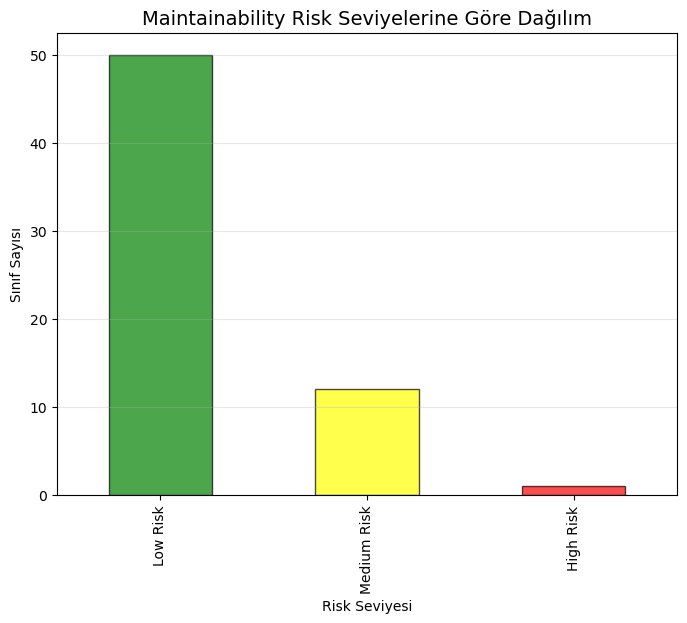

In [32]:
# Risk seviyesi dağılımı
plt.figure(figsize=(8, 6))
risk_distribution.plot(kind='bar', color=['green', 'yellow', 'red'], alpha=0.7, edgecolor='black')
plt.title("Maintainability Risk Seviyelerine Göre Dağılım", fontsize=14)
plt.xlabel("Risk Seviyesi")
plt.ylabel("Sınıf Sayısı")
plt.grid(axis='y', alpha=0.3)
plt.show()


In [33]:
# Yüksek riskli sınıflar
high_risk_classes = df[df['risk_level'] == "High Risk"]

# Detaylı risk analizi
print("Yüksek Riskli Sınıflar (Detaylı):")
print(high_risk_classes[['name', 'modifiability', 'testability',]])


Yüksek Riskli Sınıflar (Detaylı):
          name  modifiability  testability
31  Class32.cs         0.6735          0.7
